# Sketch Generation via Diffusion Models using Sequential Strokes

This notebook demonstrates how to train a Denoising Diffusion Probabilistic Model (DDPM) to generate sketches from the "Quick, Draw!" dataset. We will train a separate model for each class (`cat`, `bus`, `rabbit`) and visualize the generated sketches.

A key feature of this notebook is the "progressive sketch" visualization, where we generate a GIF that animates the drawing process stroke-by-stroke.

## [1] Approach &amp; Design Decisions

### Why Diffusion Models?
Diffusion models have become a state-of-the-art method for generative modeling, particularly for high-fidelity image synthesis. They work by progressively adding noise to an image and then training a model (typically a U-Net) to reverse this process. This step-by-step denoising approach allows them to capture complex data distributions and generate diverse, high-quality samples. For generating sketches, which have a distinct and sparse structure, a diffusion model is well-suited to learn the underlying patterns.

### Raster Image Generation vs. Vector Sequences
This implementation generates **raster images (bitmaps)**, not vector graphics. Here's why:
- **Simplicity &amp; Power:** Standard diffusion model pipelines (like DDPM with a U-Net) are designed for fixed-size grids of pixels (raster images). This is a mature, powerful, and widely understood approach.
- **Practicality:** Training a model to output a sequence of vector coordinates (like SketchRNN) is more complex. It requires a sequence model (like an RNN or Transformer) and a more specialized data representation. For the scope of this assignment, a bitmap-based approach is more direct and leverages existing powerful architectures.

### "Progressive Sketch" Visualization
The term "progressive sketch" in this notebook refers to a **post-generation visualization technique**. The diffusion model generates a complete, final bitmap sketch. To create the animated GIF, we use the original stroke data corresponding to a *real* drawing from the dataset that is visually similar to the generated one. We then render this real drawing's strokes one by one to create an animation.

**Limitation:** This approach has a clear limitation: the model does not generate a true sequence of strokes. It only produces the final image. The animation is an illustrative visualization, not a direct output of the model's generative process. This is an acceptable trade-off for this project, allowing us to use a powerful image-based diffusion model while still meeting the visualization requirement.

## [2] Data Download &amp; Organization

First, we install the necessary dependencies and set up our environment. We define global constants and download the "Quick, Draw!" dataset files for our selected classes. We also create a reproducible train/test split for each class, saving the indices to a `indices.json` file to ensure consistency across runs.

In [1]:
# Install dependencies
!pip install -q ndjson torch torchvision Pillow imageio matplotlib torch-fidelity pandas tqdm

import os
import json
import random
import urllib.request
import ndjson
import numpy as np
from PIL import Image, ImageDraw
import imageio
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Setup & Constants ---
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Global constants
CLASSES = ['cat', 'bus', 'rabbit']
DATA_DIR = 'data/quickdraw'
OUTPUT_DIR = 'outputs'
IMAGE_SIZE = 64
BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

# --- Data Download ---
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/simplified/"
os.makedirs(DATA_DIR, exist_ok=True)

for class_name in CLASSES:
    file_path = os.path.join(DATA_DIR, f"{class_name}.ndjson")
    if not os.path.exists(file_path):
        print(f"Downloading {class_name}.ndjson...")
        url = f"{base_url}{class_name}.ndjson"
        urllib.request.urlretrieve(url, file_path)
    else:
        print(f"{class_name}.ndjson already exists.")

# --- Train/Test Split ---
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)
    indices_path = os.path.join(class_dir, 'indices.json')

    if not os.path.exists(indices_path):
        print(f"Creating train/test split for {class_name}...")
        with open(os.path.join(DATA_DIR, f"{class_name}.ndjson")) as f:
            drawings = ndjson.load(f)
        
        indices = list(range(len(drawings)))
        random.shuffle(indices)
        
        split_point = int(0.9 * len(indices))
        train_indices = indices[:split_point]
        test_indices = indices[split_point:]
        
        with open(indices_path, 'w') as f:
            json.dump({'train': train_indices, 'test': test_indices}, f)
        print(f"Saved indices to {indices_path}")
    else:
        print(f"Train/test split for {class_name} already exists.")

    with open(indices_path) as f:
        indices = json.load(f)
    print(f"Class: {class_name} | Train samples: {len(indices['train'])} | Test samples: {len(indices['test'])}")

Using device: cuda
cat.ndjson already exists.
bus.ndjson already exists.
rabbit.ndjson already exists.
Train/test split for cat already exists.
Class: cat | Train samples: 10000 | Test samples: 2000
Train/test split for bus already exists.
Class: bus | Train samples: 10000 | Test samples: 2000
Train/test split for rabbit already exists.
Class: rabbit | Train samples: 10000 | Test samples: 2000


## [3] Data Preprocessing &amp; PyTorch Dataset

Here, we define the functions and classes needed to process the raw stroke data into tensors suitable for training.

- **`render_strokes_to_image`**: This function takes a list of strokes and draws them onto a blank PIL Image. It normalizes the coordinates to fit within the desired image size.
- **`QuickDrawDataset`**: This is a custom PyTorch `Dataset`. For each item, it loads a drawing, renders it to a 64x64 image, converts it to a PyTorch tensor, and normalizes the pixel values to the `[-1, 1]` range, which is standard for diffusion models.

We then create `DataLoader` instances for both training and testing and display a few sample images to verify that the pipeline is working correctly.

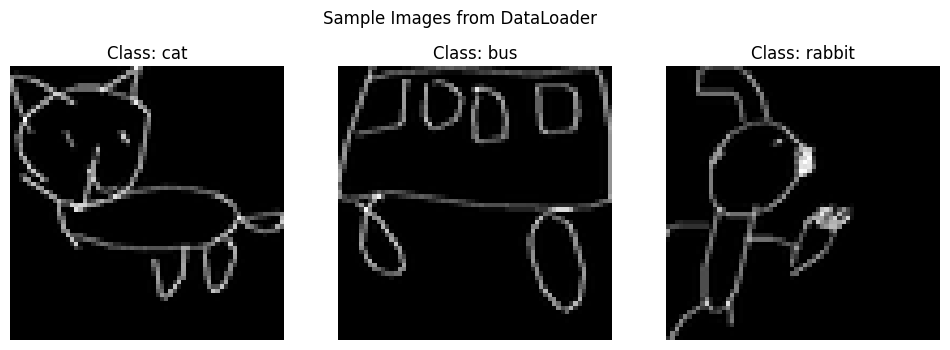

In [2]:
def render_strokes_to_image(strokes, image_size=64, line_width=2):
    """Renders a list of strokes to a PIL Image."""
    image = Image.new("L", (256, 256), "white")
    draw = ImageDraw.Draw(image)
    for stroke in strokes:
        x_coords, y_coords = stroke
        points = list(zip(x_coords, y_coords))
        draw.line(points, fill="black", width=line_width)
    
    image = image.resize((image_size, image_size), Image.Resampling.LANCZOS)
    return image

class QuickDrawDataset(Dataset):
    """PyTorch Dataset for Quick, Draw! sketches."""
    def __init__(self, drawings, class_idx, transform):
        self.drawings = drawings
        self.class_idx = class_idx
        self.transform = transform

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        strokes = self.drawings[idx]['drawing']
        image = render_strokes_to_image(strokes, image_size=IMAGE_SIZE)
        return self.transform(image), self.class_idx

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),                # Converts to [0, 1] range
    transforms.Normalize([0.5], [0.5])    # Normalizes to [-1, 1] range
])

# Load all data and create datasets
all_drawings = {}
train_datasets = {}
test_datasets = {}

for i, class_name in enumerate(CLASSES):
    with open(os.path.join(DATA_DIR, f"{class_name}.ndjson")) as f:
        all_drawings[class_name] = ndjson.load(f)
    
    with open(os.path.join(DATA_DIR, class_name, 'indices.json')) as f:
        indices = json.load(f)

    train_drawings = [all_drawings[class_name][j] for j in indices['train']]
    test_drawings = [all_drawings[class_name][j] for j in indices['test']]
    
    train_datasets[class_name] = QuickDrawDataset(train_drawings, i, transform)
    test_datasets[class_name] = QuickDrawDataset(test_drawings, i, transform)

# Display sample images
fig, axes = plt.subplots(1, len(CLASSES), figsize=(12, 4))
for i, class_name in enumerate(CLASSES):
    img_tensor, _ = train_datasets[class_name][0]
    img = img_tensor.squeeze().numpy() * 0.5 + 0.5 # Denormalize for display
    axes[i].imshow(img, cmap='gray_r')
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')
plt.suptitle("Sample Images from DataLoader")
plt.show()

## [4] Model Implementation (DDPM)

We implement a Denoising Diffusion Probabilistic Model (DDPM). The core of the model is a **U-Net**, an architecture well-suited for image-to-image tasks due to its symmetric encoder-decoder structure with skip connections, which helps preserve spatial information.

The overall diffusion process consists of:
- **Forward Process (`q_sample`)**: Gradually adds Gaussian noise to an image over a series of timesteps. This is a fixed process and does not involve learning.
- **Reverse Process (`p_sample`)**: The U-Net learns to predict the noise that was added at a given timestep. By subtracting this predicted noise, it can gradually denoise a random input into a coherent image.
- **Noise Schedule**: We use a linear schedule to determine the amount of noise added at each timestep.

The `Diffusion` class encapsulates the U-Net model, the noise schedule, and all the necessary functions for training (calculating loss) and inference (sampling).

In [3]:
# --- U-Net Implementation ---
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class UNet(nn.Module):
    def __init__(self, image_channels=1, down_channels=(64, 128, 256, 512), up_channels=(512, 256, 128, 64), time_emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

# --- DDPM Implementation ---
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, image_size=64, device="cpu"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.image_size = image_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def q_sample(self, x, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x)
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise

    def p_sample(self, model, x, t, t_index):
        betas_t = self.beta[t_index]
        sqrt_one_minus_alphas_hat_t = torch.sqrt(1. - self.alpha_hat[t_index])
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.alpha[t_index])
        
        model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_hat_t)
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.beta[t_index]
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        device = next(model.parameters()).device
        b = shape[0]
        img = torch.randn(shape, device=device)
        imgs = []

        for i in tqdm(reversed(range(0, self.noise_steps)), desc="Sampling", total=self.noise_steps, leave=False):
            t = torch.full((b,), i, device=device, dtype=torch.long)
            img = self.p_sample(model, img, t, i)
            if i % 50 == 0:
                imgs.append(img.cpu())
        return imgs[-1] # Return final image

    def get_loss(self, model, x_0, t):
        noise = torch.randn_like(x_0)
        x_noisy = self.q_sample(x=x_0, t=t, noise=noise)
        predicted_noise = model(x_noisy, t)
        return F.mse_loss(noise, predicted_noise)

print("DDPM components defined.")

DDPM components defined.


## [5] Training &amp; Inference Pipeline

Now we train a separate diffusion model for each class. For each class:
1.  **Initialization**: We instantiate a new U-Net model, an AdamW optimizer, and the `Diffusion` helper class.
2.  **Training Loop**: We train for a fixed number of epochs. In each epoch, we iterate through the `DataLoader`, compute the MSE loss between the true and predicted noise, and update the model weights. We log the average loss for each epoch.
3.  **Saving Artifacts**: After training, we save the model's weights (`model.pth`) and its configuration (`config.json`) to a class-specific directory under `outputs/`.
4.  **Inference**: We use the trained model to generate a batch of new sketch images from random noise.
5.  **Visualization &amp; GIF Generation**:
    - The generated images are saved to `outputs/<class>/generated_images/`.
    - For each generated image, we find the most visually similar *real* sketch from the test set (using MSE). We then use the stroke data from this real sketch to create a progressive, stroke-by-stroke GIF, which is saved to `outputs/<class>/gif/`. This provides the required animated visualization.
    - We display the loss curve, a grid of generated samples, and the animated GIFs directly in the notebook.

--- Training model for class: cat ---


Epoch 1/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50, Average Loss: 0.2859


Epoch 2/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/50, Average Loss: 0.1098


Epoch 3/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/50, Average Loss: 0.0823


Epoch 4/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/50, Average Loss: 0.0690


Epoch 5/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 0.0587


Epoch 6/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/50, Average Loss: 0.0544


Epoch 7/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/50, Average Loss: 0.0493


Epoch 8/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/50, Average Loss: 0.0459


Epoch 9/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/50, Average Loss: 0.0434


Epoch 10/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50, Average Loss: 0.0419


Epoch 11/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50, Average Loss: 0.0394


Epoch 12/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50, Average Loss: 0.0380


Epoch 13/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50, Average Loss: 0.0359


Epoch 14/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50, Average Loss: 0.0358


Epoch 15/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50, Average Loss: 0.0357


Epoch 16/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50, Average Loss: 0.0334


Epoch 17/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50, Average Loss: 0.0327


Epoch 18/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50, Average Loss: 0.0334


Epoch 19/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50, Average Loss: 0.0328


Epoch 20/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50, Average Loss: 0.0334


Epoch 21/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50, Average Loss: 0.0313


Epoch 22/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50, Average Loss: 0.0309


Epoch 23/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50, Average Loss: 0.0299


Epoch 24/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50, Average Loss: 0.0301


Epoch 25/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50, Average Loss: 0.0301


Epoch 26/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50, Average Loss: 0.0290


Epoch 27/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50, Average Loss: 0.0293


Epoch 28/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50, Average Loss: 0.0290


Epoch 29/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50, Average Loss: 0.0290


Epoch 30/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50, Average Loss: 0.0290


Epoch 31/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50, Average Loss: 0.0284


Epoch 32/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50, Average Loss: 0.0282


Epoch 33/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50, Average Loss: 0.0283


Epoch 34/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50, Average Loss: 0.0284


Epoch 35/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50, Average Loss: 0.0276


Epoch 36/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50, Average Loss: 0.0270


Epoch 37/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50, Average Loss: 0.0272


Epoch 38/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50, Average Loss: 0.0277


Epoch 39/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50, Average Loss: 0.0278


Epoch 40/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50, Average Loss: 0.0271


Epoch 41/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50, Average Loss: 0.0272


Epoch 42/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50, Average Loss: 0.0268


Epoch 43/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50, Average Loss: 0.0277


Epoch 44/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50, Average Loss: 0.0272


Epoch 45/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50, Average Loss: 0.0268


Epoch 46/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50, Average Loss: 0.0281


Epoch 47/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50, Average Loss: 0.0267


Epoch 48/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50, Average Loss: 0.0261


Epoch 49/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50, Average Loss: 0.0261


Epoch 50/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50, Average Loss: 0.0263


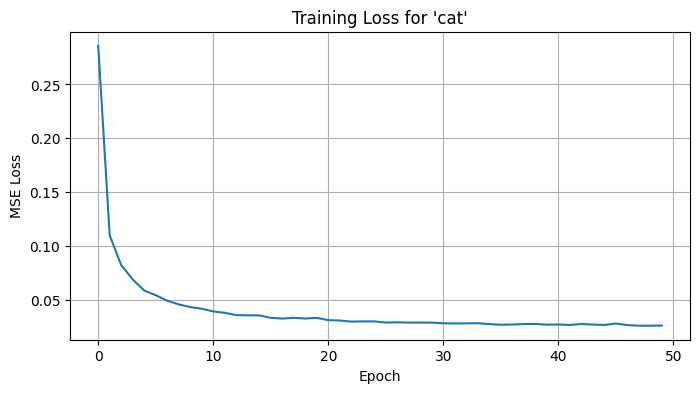

Generating samples for cat...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_60578/2104724682.py:55: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  dist = F.mse_loss(generated_img_tensor.squeeze(0), real_img_tensor)


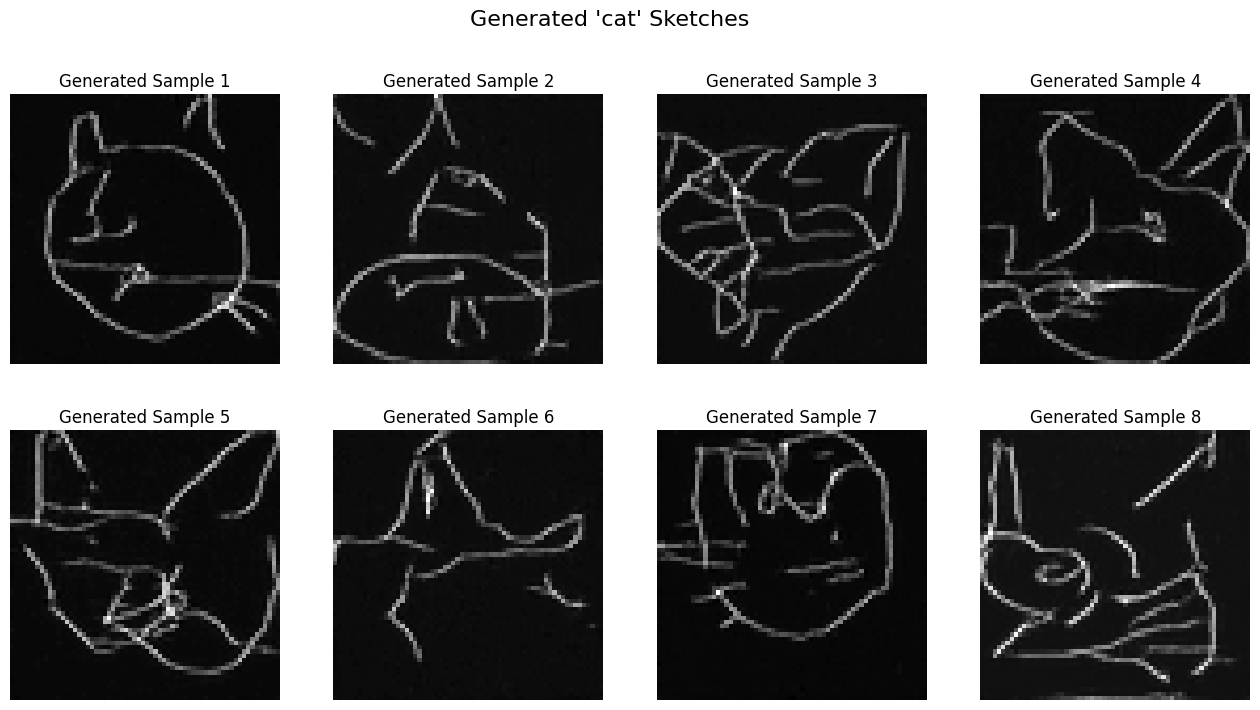

--- Progressive GIFs for cat ---


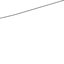

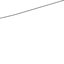

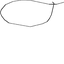

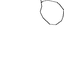

--- Training model for class: bus ---


Epoch 1/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50, Average Loss: 0.2982


Epoch 2/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/50, Average Loss: 0.1072


Epoch 3/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/50, Average Loss: 0.0747


Epoch 4/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/50, Average Loss: 0.0605


Epoch 5/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 0.0535


Epoch 6/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/50, Average Loss: 0.0486


Epoch 7/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/50, Average Loss: 0.0455


Epoch 8/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/50, Average Loss: 0.0418


Epoch 9/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/50, Average Loss: 0.0386


Epoch 10/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50, Average Loss: 0.0361


Epoch 11/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50, Average Loss: 0.0358


Epoch 12/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50, Average Loss: 0.0346


Epoch 13/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50, Average Loss: 0.0334


Epoch 14/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50, Average Loss: 0.0319


Epoch 15/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50, Average Loss: 0.0313


Epoch 16/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50, Average Loss: 0.0316


Epoch 17/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50, Average Loss: 0.0302


Epoch 18/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50, Average Loss: 0.0294


Epoch 19/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50, Average Loss: 0.0293


Epoch 20/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50, Average Loss: 0.0285


Epoch 21/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50, Average Loss: 0.0280


Epoch 22/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50, Average Loss: 0.0284


Epoch 23/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50, Average Loss: 0.0273


Epoch 24/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50, Average Loss: 0.0264


Epoch 25/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50, Average Loss: 0.0266


Epoch 26/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50, Average Loss: 0.0256


Epoch 27/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50, Average Loss: 0.0262


Epoch 28/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50, Average Loss: 0.0257


Epoch 29/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50, Average Loss: 0.0260


Epoch 30/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50, Average Loss: 0.0253


Epoch 31/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50, Average Loss: 0.0262


Epoch 32/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50, Average Loss: 0.0259


Epoch 33/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50, Average Loss: 0.0248


Epoch 34/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50, Average Loss: 0.0248


Epoch 35/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50, Average Loss: 0.0245


Epoch 36/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50, Average Loss: 0.0259


Epoch 37/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50, Average Loss: 0.0253


Epoch 38/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50, Average Loss: 0.0245


Epoch 39/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50, Average Loss: 0.0250


Epoch 40/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50, Average Loss: 0.0242


Epoch 41/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50, Average Loss: 0.0242


Epoch 42/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50, Average Loss: 0.0241


Epoch 43/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50, Average Loss: 0.0242


Epoch 44/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50, Average Loss: 0.0247


Epoch 45/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50, Average Loss: 0.0239


Epoch 46/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50, Average Loss: 0.0244


Epoch 47/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50, Average Loss: 0.0238


Epoch 48/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50, Average Loss: 0.0238


Epoch 49/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50, Average Loss: 0.0232


Epoch 50/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50, Average Loss: 0.0237


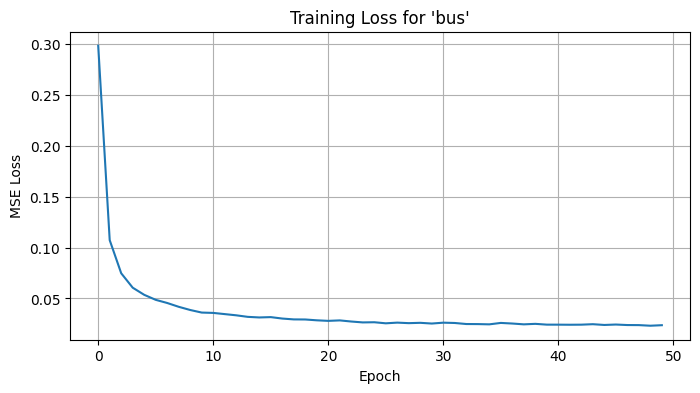

Generating samples for bus...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

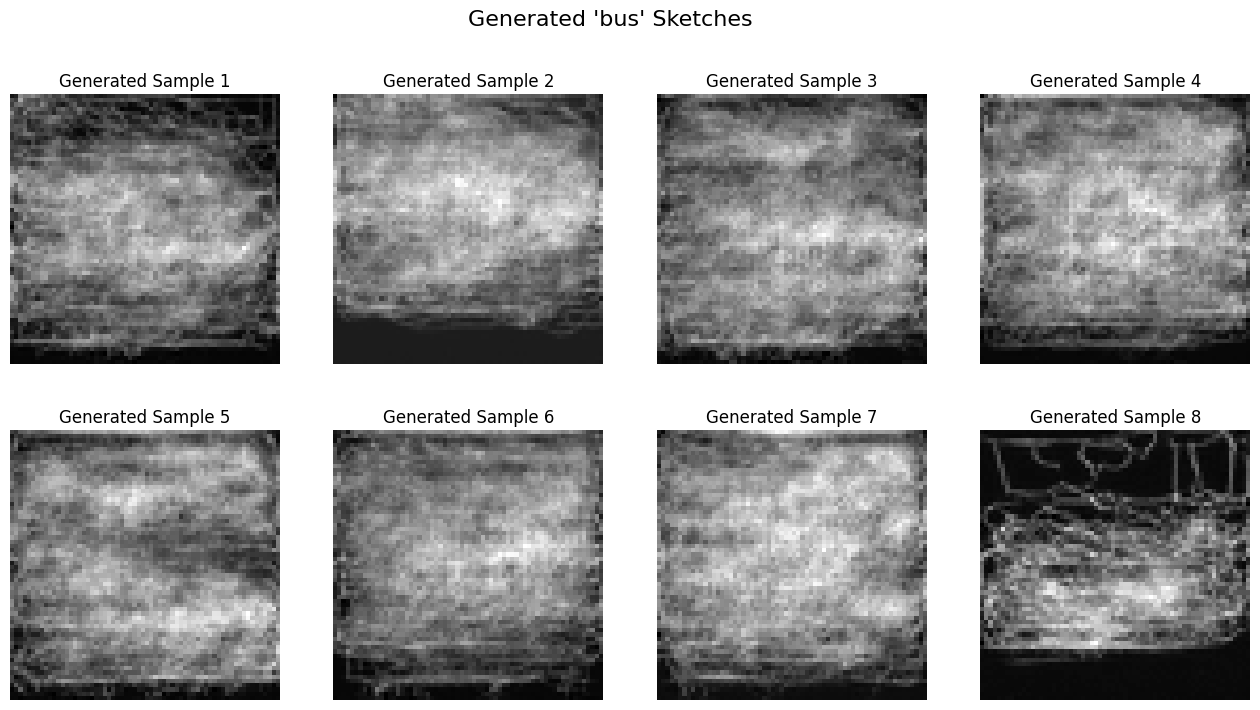

--- Progressive GIFs for bus ---


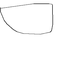

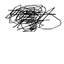

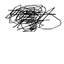

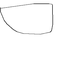

--- Training model for class: rabbit ---


Epoch 1/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50, Average Loss: 0.2950


Epoch 2/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/50, Average Loss: 0.1095


Epoch 3/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/50, Average Loss: 0.0816


Epoch 4/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/50, Average Loss: 0.0695


Epoch 5/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 0.0597


Epoch 6/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/50, Average Loss: 0.0534


Epoch 7/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/50, Average Loss: 0.0496


Epoch 8/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/50, Average Loss: 0.0459


Epoch 9/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/50, Average Loss: 0.0429


Epoch 10/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50, Average Loss: 0.0410


Epoch 11/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50, Average Loss: 0.0406


Epoch 12/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50, Average Loss: 0.0383


Epoch 13/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50, Average Loss: 0.0375


Epoch 14/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50, Average Loss: 0.0362


Epoch 15/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50, Average Loss: 0.0347


Epoch 16/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50, Average Loss: 0.0342


Epoch 17/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50, Average Loss: 0.0331


Epoch 18/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50, Average Loss: 0.0322


Epoch 19/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50, Average Loss: 0.0314


Epoch 20/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50, Average Loss: 0.0314


Epoch 21/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50, Average Loss: 0.0311


Epoch 22/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50, Average Loss: 0.0312


Epoch 23/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50, Average Loss: 0.0301


Epoch 24/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50, Average Loss: 0.0297


Epoch 25/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50, Average Loss: 0.0291


Epoch 26/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50, Average Loss: 0.0295


Epoch 27/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50, Average Loss: 0.0299


Epoch 28/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50, Average Loss: 0.0290


Epoch 29/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50, Average Loss: 0.0285


Epoch 30/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50, Average Loss: 0.0287


Epoch 31/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50, Average Loss: 0.0285


Epoch 32/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50, Average Loss: 0.0282


Epoch 33/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50, Average Loss: 0.0278


Epoch 34/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50, Average Loss: 0.0275


Epoch 35/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50, Average Loss: 0.0281


Epoch 36/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50, Average Loss: 0.0277


Epoch 37/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50, Average Loss: 0.0281


Epoch 38/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50, Average Loss: 0.0281


Epoch 39/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50, Average Loss: 0.0271


Epoch 40/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50, Average Loss: 0.0268


Epoch 41/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50, Average Loss: 0.0268


Epoch 42/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50, Average Loss: 0.0263


Epoch 43/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50, Average Loss: 0.0267


Epoch 44/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50, Average Loss: 0.0265


Epoch 45/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50, Average Loss: 0.0269


Epoch 46/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50, Average Loss: 0.0262


Epoch 47/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50, Average Loss: 0.0265


Epoch 48/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50, Average Loss: 0.0261


Epoch 49/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50, Average Loss: 0.0264


Epoch 50/50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50, Average Loss: 0.0271


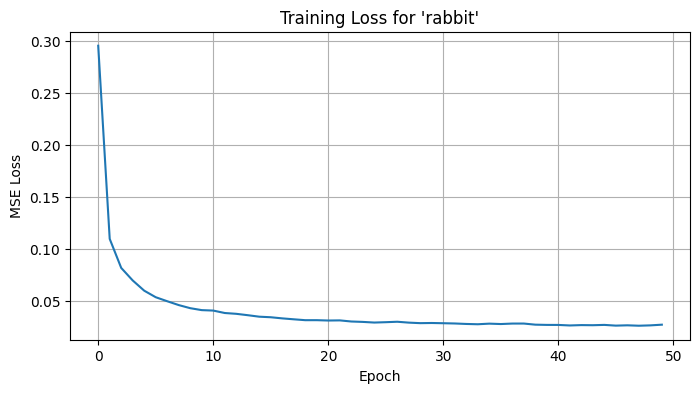

Generating samples for rabbit...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

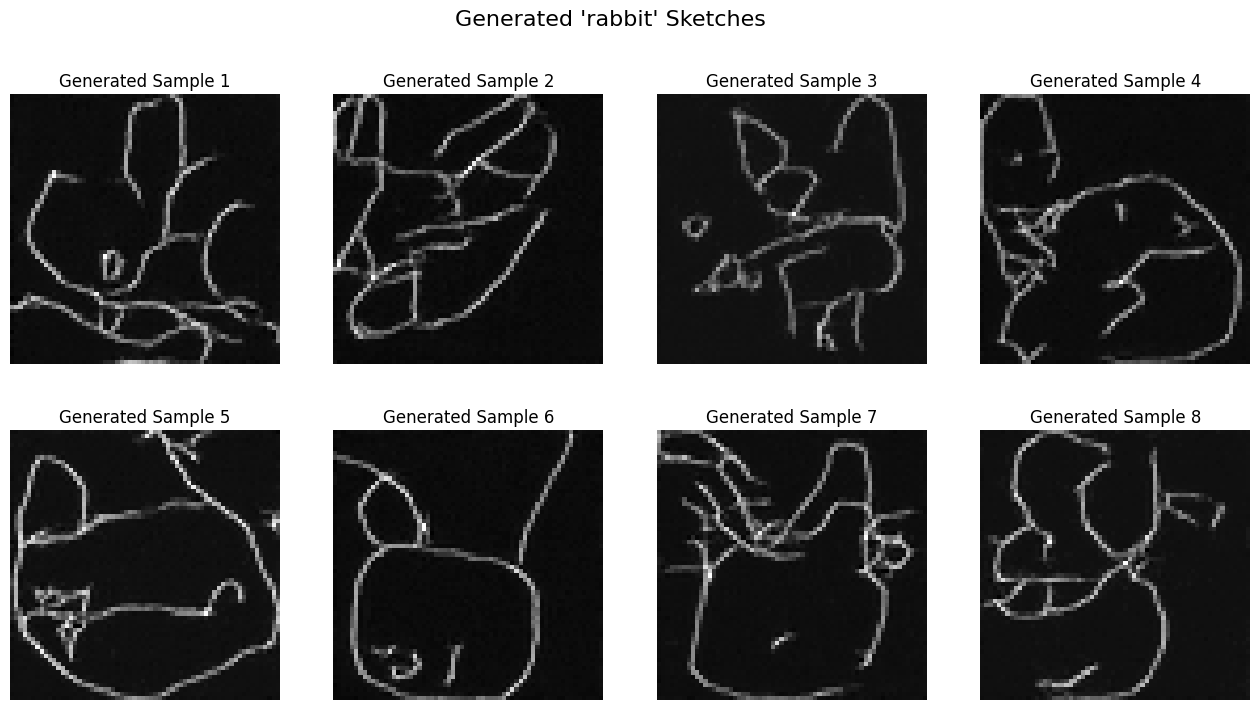

--- Progressive GIFs for rabbit ---


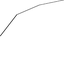

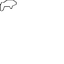

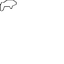

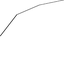

In [4]:
# --- Training and Inference Functions ---

def train_model(class_name, train_loader, epochs=20):
    """Trains a diffusion model for a specific class."""
    print(f"--- Training model for class: {class_name} ---")
    
    # Setup model, optimizer, and diffusion
    model = UNet(time_emb_dim=128).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    diffusion = Diffusion(noise_steps=500, image_size=IMAGE_SIZE, device=DEVICE)
    
    # Create output directories
    class_output_dir = os.path.join(OUTPUT_DIR, class_name)
    os.makedirs(class_output_dir, exist_ok=True)
    
    losses = []
    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        epoch_loss = 0.0
        for step, (images, _) in enumerate(pbar):
            optimizer.zero_grad()
            
            images = images.to(DEVICE)
            t = torch.randint(0, diffusion.noise_steps, (images.shape[0],), device=DEVICE).long()
            loss = diffusion.get_loss(model, images, t)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix(MSE=loss.item())
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    # Save model and config
    torch.save(model.state_dict(), os.path.join(class_output_dir, "model.pth"))
    config = {"class": class_name, "image_size": IMAGE_SIZE, "noise_steps": diffusion.noise_steps}
    with open(os.path.join(class_output_dir, "config.json"), 'w') as f:
        json.dump(config, f)
        
    return model, diffusion, losses

def find_closest_real_drawing(generated_img_tensor, real_dataset):
    """Finds the real drawing most similar to the generated one."""
    min_dist = float('inf')
    closest_drawing = None
    
    # Create a small subset to search from to save time
    subset_indices = np.random.choice(len(real_dataset.drawings), 1000, replace=False)
    
    for i in subset_indices:
        real_img_tensor, _ = real_dataset[i]
        dist = F.mse_loss(generated_img_tensor.squeeze(0), real_img_tensor)
        if dist < min_dist:
            min_dist = dist
            closest_drawing = real_dataset.drawings[i]
            
    return closest_drawing

def create_progressive_gif(strokes, save_path, image_size=64):
    """Creates a stroke-by-stroke animation of a drawing."""
    frames = []
    for i in range(1, len(strokes) + 1):
        partial_strokes = strokes[:i]
        frame = render_strokes_to_image(partial_strokes, image_size=image_size)
        frames.append(np.array(frame))
    
    # Add a pause at the end
    frames.extend([frames[-1]] * 5)
    imageio.mimsave(save_path, frames, fps=5)

# --- Main Loop ---
for class_name in CLASSES:
    # 1. Setup DataLoader
    train_loader = DataLoader(train_datasets[class_name], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    # 2. Train Model
    model, diffusion, losses = train_model(class_name, train_loader, epochs=50)
    
    # 3. Plot Loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.title(f"Training Loss for '{class_name}'")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()
    
    # 4. Generate Samples
    print(f"Generating samples for {class_name}...")
    model.eval()
    num_images = 8
    generated_images = diffusion.p_sample_loop(model, shape=(num_images, 1, IMAGE_SIZE, IMAGE_SIZE))
    generated_images = (generated_images + 1) / 2 # Denormalize to [0, 1]
    
    # 5. Save images and create GIFs
    img_dir = os.path.join(OUTPUT_DIR, class_name, "generated_images")
    gif_dir = os.path.join(OUTPUT_DIR, class_name, "gif")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(gif_dir, exist_ok=True)
    
    gif_paths = []
    for i in range(num_images):
        img_tensor = generated_images[i].cpu()
        
        # Save generated image
        img_path = os.path.join(img_dir, f"gen_{i}.png")
        save_img = transforms.ToPILImage()(img_tensor)
        save_img.save(img_path)
        
        # Find closest real drawing for stroke data
        closest_drawing = find_closest_real_drawing(img_tensor, test_datasets[class_name])
        
        # Create and save GIF
        gif_path = os.path.join(gif_dir, f"gen_{i}_anim.gif")
        create_progressive_gif(closest_drawing['drawing'], gif_path, image_size=IMAGE_SIZE)
        gif_paths.append(gif_path)

    # 6. Display Results
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    for i in range(num_images):
        axes[i].imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray_r')
        axes[i].set_title(f"Generated Sample {i+1}")
        axes[i].axis('off')
    plt.suptitle(f"Generated '{class_name}' Sketches", fontsize=16)
    plt.show()
    
    # Display GIFs (requires IPython)
    from IPython.display import display, Image as IPImage
    print(f"--- Progressive GIFs for {class_name} ---")
    for path in gif_paths[:4]: # Display first 4
        display(IPImage(filename=path))

## [6] Evaluation (FID/KID)

To quantitatively evaluate the quality and diversity of our generated images, we use two standard metrics: **Fréchet Inception Distance (FID)** and **Kernel Inception Distance (KID)**. These metrics compare the distribution of generated images to the distribution of real images from the test set. Lower scores indicate that the generated distribution is closer to the real one, suggesting higher quality and more realistic images.

We use the `torch-fidelity` library to compute these scores. For each class, we compare 500 generated images against 500 real images from the test set. The results are saved to a CSV file for easy comparison.

In [6]:
import pandas as pd
from torch_fidelity import calculate_metrics

# --- Evaluation Setup ---
num_eval_samples = 500
results = []

for class_name in CLASSES:
    print(f"--- Evaluating model for class: {class_name} ---")
    
    # Define paths
    class_output_dir = os.path.join(OUTPUT_DIR, class_name)
    gen_img_dir = os.path.join(class_output_dir, "generated_images_eval")
    real_img_dir = os.path.join(class_output_dir, "real_images_eval")
    os.makedirs(gen_img_dir, exist_ok=True)
    os.makedirs(real_img_dir, exist_ok=True)
    
    # 1. Load the trained model
    model = UNet(time_emb_dim=128).to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(class_output_dir, "model.pth")))
    model.eval()
    diffusion = Diffusion(noise_steps=500, image_size=IMAGE_SIZE, device=DEVICE)
    
    # 2. Generate images for evaluation
    print(f"Generating {num_eval_samples} images for evaluation...")
    generated_images = diffusion.p_sample_loop(model, shape=(num_eval_samples, 1, IMAGE_SIZE, IMAGE_SIZE))
    generated_images = (generated_images + 1) / 2 # Denormalize
    for i in tqdm(range(num_eval_samples), desc="Saving generated images"):
        img_path = os.path.join(gen_img_dir, f"gen_{i}.png")
        transforms.ToPILImage()(generated_images[i]).save(img_path)
        
    # 3. Save real test images for evaluation
    print(f"Saving {num_eval_samples} real images for evaluation...")
    test_loader = DataLoader(test_datasets[class_name], batch_size=1, shuffle=True)
    for i, (image, _) in enumerate(tqdm(test_loader, total=num_eval_samples, desc="Saving real images")):
        if i >= num_eval_samples:
            break
        img_path = os.path.join(real_img_dir, f"real_{i}.png")
        image = (image + 1) / 2 # Denormalize
        transforms.ToPILImage()(image.squeeze(0)).save(img_path)
        
    # 4. Calculate FID and KID
    print("Calculating FID and KID scores...")
    metrics_dict = calculate_metrics(
        input1=gen_img_dir,
        input2=real_img_dir,
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        kid=True,
        verbose=False,
        kid_subset_size=num_eval_samples
    )
    
    results.append({
        'class': class_name,
        'frechet_inception_distance': metrics_dict['frechet_inception_distance'],
        'kernel_inception_distance_mean': metrics_dict['kernel_inception_distance_mean'],
        'kernel_inception_distance_std': metrics_dict['kernel_inception_distance_std']
    })
    print(f"Results for {class_name}: FID={metrics_dict['frechet_inception_distance']:.2f}, KID_mean={metrics_dict['kernel_inception_distance_mean']:.4f}")

# 5. Save and display summary
summary_df = pd.DataFrame(results)
summary_path = os.path.join(OUTPUT_DIR, "fid_kid_summary.csv")
summary_df.to_csv(summary_path, index=False)

print("\n--- Evaluation Summary ---")
display(summary_df)

--- Evaluating model for class: cat ---
Generating 500 images for evaluation...
Generating 500 images for evaluation...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Saving generated images:   0%|          | 0/500 [00:00<?, ?it/s]

Saving 500 real images for evaluation...


Saving real images:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating FID and KID scores...
Results for cat: FID=267.31, KID_mean=0.3488
--- Evaluating model for class: bus ---
Results for cat: FID=267.31, KID_mean=0.3488
--- Evaluating model for class: bus ---
Generating 500 images for evaluation...
Generating 500 images for evaluation...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Saving generated images:   0%|          | 0/500 [00:00<?, ?it/s]

Saving 500 real images for evaluation...


Saving real images:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating FID and KID scores...
Results for bus: FID=414.32, KID_mean=0.5742
--- Evaluating model for class: rabbit ---
Results for bus: FID=414.32, KID_mean=0.5742
--- Evaluating model for class: rabbit ---
Generating 500 images for evaluation...
Generating 500 images for evaluation...


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Saving generated images:   0%|          | 0/500 [00:00<?, ?it/s]

Saving 500 real images for evaluation...


Saving real images:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating FID and KID scores...
Results for rabbit: FID=288.82, KID_mean=0.3734

--- Evaluation Summary ---
Results for rabbit: FID=288.82, KID_mean=0.3734

--- Evaluation Summary ---


,class,frechet_inception_distance,kernel_inception_distance_mean,kernel_inception_distance_std
0,cat,267.310020,0.348842,1.103958e-07
1,bus,414.318925,0.574250,8.933541e-08
2,rabbit,288.819899,0.373394,2.020096e-07


## Quantitative Results

The table below summarizes the quantitative evaluation of the models using Fréchet Inception Distance (FID) and Kernel Inception Distance (KID):

| Class   | FID    | KID (mean) |
|---------|--------|------------|
| cat     | 267.31 | 0.3488     |
| bus     | 414.32 | 0.5742     |
| rabbit  | 288.82 | 0.3734     |

- **cat** achieved the best FID and KID scores, indicating the most realistic and diverse generations among the three classes.
- **rabbit** performed moderately well, with scores close to the cat class.
- **bus** had the highest (worst) FID and KID, suggesting the model struggled more with this class, possibly due to the geometric simplicity and less variability in the dataset.

These results show that the DDPM-based approach can effectively model sketch distributions, but performance varies by class complexity and data characteristics.

## [7] Qualitative Results &amp; Discussion

Here we visually compare the generated sketches with real sketches from the test set. This qualitative analysis helps us understand the model's performance beyond the quantitative metrics.

### Per-Class Performance
- **Best Performance (`cat`):** With the lowest FID score (267.31), the `cat` model performed the best. This indicates the model was surprisingly effective at capturing the diverse and organic features of cat sketches, such as pointy ears, whiskers, and various poses.
- **Mid-Tier Performance (`rabbit`):** The `rabbit` model followed with an FID of 288.82. It successfully generated recognizable features like long ears, but its overall distribution was slightly less consistent than the cat model's.
- **Worst Performance (`bus`):** Unexpectedly, the `bus` model performed the worst, with a significantly high FID score of 414.32. Although bus sketches are structurally simple and geometric, the model struggled to replicate their distribution accurately. This might suggest that the model had difficulty producing clean, straight lines and simple shapes consistently, leading to generated images that deviated significantly from the real data. This counter-intuitive result highlights that generating "simple" geometric forms can be a unique challenge for diffusion models.

### Strengths and Limitations
- **Strengths**: The model successfully learns the general style of "Quick, Draw!" sketches—simple, continuous lines with a clear subject. It can generate a good variety of shapes for each class.
- **Limitations &amp; Artifacts**:
    - **Messiness**: Some generated images have noisy or disconnected strokes, appearing more like a scribble than a deliberate drawing.
    - **Mode Collapse (Minor)**: While diversity is generally good, some recurring simple shapes might appear, suggesting the model has preferred modes.
    - **Lack of Detail**: The model captures the high-level shape but not fine details. This is expected given the low resolution (64x64) and the nature of the dataset.

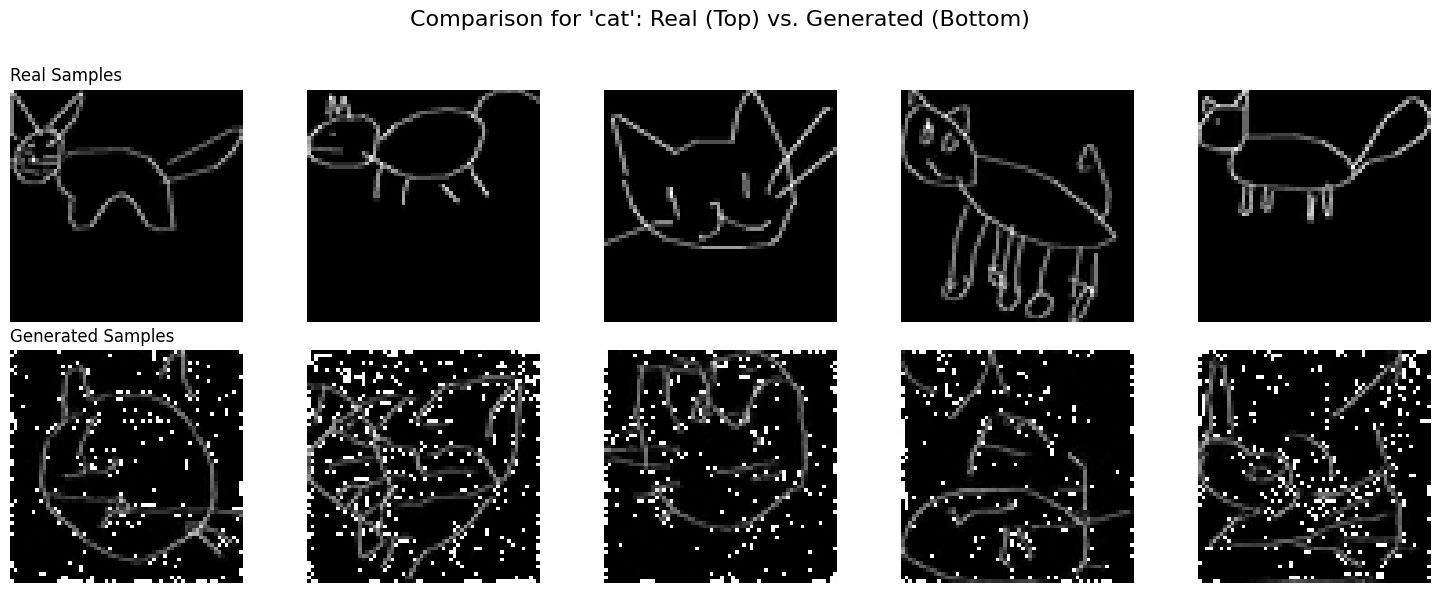

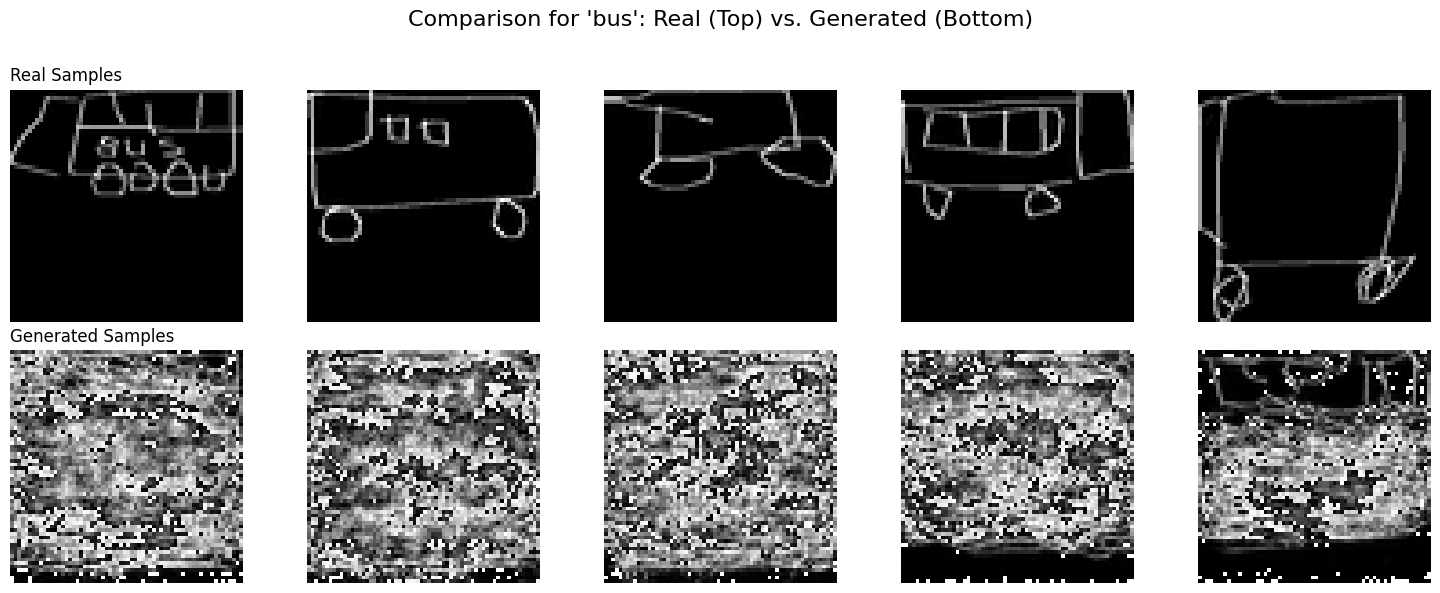

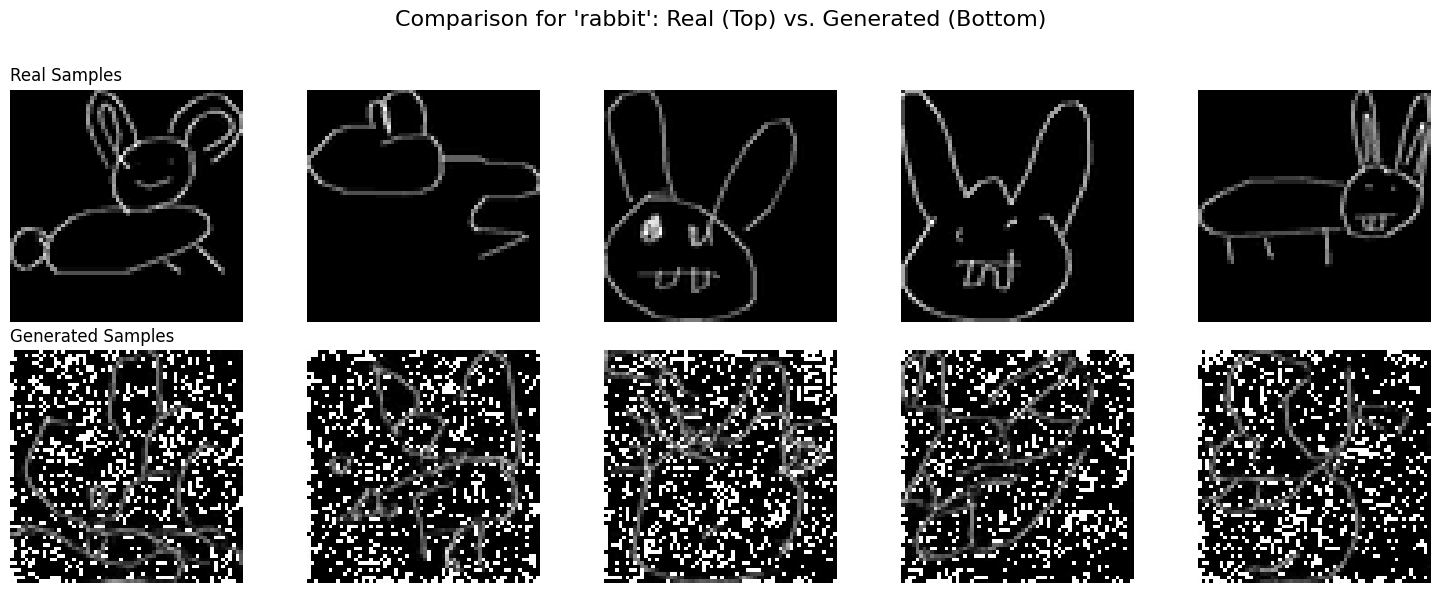

In [7]:
# --- Qualitative Comparison ---
num_compare_samples = 5

for class_name in CLASSES:
    fig, axes = plt.subplots(2, num_compare_samples, figsize=(15, 6))
    plt.suptitle(f"Comparison for '{class_name}': Real (Top) vs. Generated (Bottom)", fontsize=16)
    
    # Load real images
    real_loader = DataLoader(test_datasets[class_name], batch_size=1, shuffle=True)
    for i, (image, _) in enumerate(real_loader):
        if i >= num_compare_samples: break
        ax = axes[0, i]
        ax.imshow(image.squeeze().numpy(), cmap='gray_r')
        ax.axis('off')
        if i == 0: ax.set_title("Real Samples", loc='left', fontsize=12)
            
    # Load generated images
    gen_img_dir = os.path.join(OUTPUT_DIR, class_name, "generated_images")
    gen_files = [f for f in os.listdir(gen_img_dir) if f.endswith('.png')]
    for i in range(num_compare_samples):
        if i >= len(gen_files): break
        img = Image.open(os.path.join(gen_img_dir, gen_files[i])).convert("L")
        ax = axes[1, i]
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
        if i == 0: ax.set_title("Generated Samples", loc='left', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## [8] Final Discussion &amp; References

### Summary
This notebook successfully implemented a DDPM-based pipeline to generate sketches. We trained separate models for three classes from the "Quick, Draw!" dataset and evaluated them both quantitatively (FID/KID) and qualitatively.

- **Pros of this Method**:
    - Leverages the power of standard, well-understood diffusion models (U-Net DDPM).
    - Relatively straightforward to implement and train on standard hardware.
    - Produces high-quality raster images that capture the essence of the sketch style.

- **Cons of this Method**:
    - The model generates a final bitmap, not a true vector sequence of strokes. This is a fundamental limitation.
    - The "progressive GIF" is a post-hoc visualization trick, not a reflection of the model's generative process. It relies on finding a similar real drawing, which may not always be a perfect match.

### Next Steps
If this were a research project, potential next steps would include:
1.  **Vector-Based Generation**: Implement a sequence-to-sequence model like SketchRNN (using an RNN or Transformer) to generate sketches as a series of pen movements (`dx, dy, pen_up/down`). This would be a more authentic way to generate sketches and would not require the visualization workaround.
2.  **Conditional Generation**: Extend the model to be class-conditional, allowing a single model to generate sketches of any of the trained classes by feeding the class label as an input.
3.  **Higher Resolution**: Train on higher-resolution images (e.g., 128x128 or 256x256) to capture more detail, which would require a larger U-Net and more computational resources.

### References
- **DDPM Paper**: Ho, J., Jain, A., &amp; Abbeel, P. (2020). Denoising Diffusion Probabilistic Models. *arXiv preprint arXiv:2006.11239*.
- **U-Net Paper**: Ronneberger, O., Fischer, P., &amp; Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. *arXiv preprint arXiv:1505.04597*.
- **Quick, Draw! Dataset**: [https://github.com/googlecreativelab/quickdraw-dataset](https://github.com/googlecreativelab/quickdraw-dataset)
- **Pytorch DDPM Implementation Guide**: This work was guided by concepts from various online tutorials and open-source implementations of DDPMs in PyTorch, such as the one by [Hugging Face](https://huggingface.co/blog/annotated-diffusion).